# Simulations of the Dual Shock and Degradation Model

This code written by Ryan White is used in the paper:

Jewgeni H. Dshalalow and Ryan T. White. Random Walk Analysis in a Reliability System Under Constant Degradation, Random Soft Shocks, and Fatal Shocks.

## Exponential $\delta_i$ and $X_i$

Assume $X_i$'s are *i.i.d.* with exponential($\lambda$) and $\delta_i$'s are independent of $X_i$'s and *i.i.d* exponential($\mu$), and a single hard shock occurs with probability $p$ is treated as fatal ($N=1$).

* Note that the `numpy` implementation of exponential random number generator uses the inverse of the parameter we use.
* We will write a function that simulates one path of the process to be re-called in Monte Carlo simulation.


### The function will take inputs:

 * The parameter of the soft shock magnitude $\lambda$ (called `lam` to avoid the Python reserved command `lambda`)
 * The probability the hard shock magnitude is zero $p=P\{Y>0\}$ (`p`)
 * The parameter of the times between shocks $\mu$ (`mu`)
 * The decay rate $a$ (`a`)
 * The threshold $M$ (`M`)

### The function will return:

 * The cause of failure (degradation, soft shock, or fatal shock)
 * The times $t_{\rho-1}$ and $\eta_\rho$
 * The constant degradation + soft shock damage at time $t_{\rho-1}$
 * The constant degradation + soft shock damage at time $\eta_\rho$
 * The fatal shock damage at time $t_{\rho-1}$
 * The fatal shock damage at time $\eta_\rho$

In [271]:
import matplotlib.pyplot as plt

In [37]:
import numpy as np

def simulatePath(a, lam, mu, p, M):
    # initialize outputs
    failureTime = 0
    failureDamage = 0
    failureIndex = 0
    hardDamage = 0
    degradationFailure = False
    softFailure = False
    dualFailure = False
    hardFailure = False

    # simulate the process
    while failureDamage < M and hardDamage < 1:
        # save A_j-1
        oldDamage = failureDamage
        
        # save B_j-1
        oldHardDamage = hardDamage

        # save t_j-1
        oldTime = failureTime

        # compute waiting time before the next shock
        waitingTime = np.random.exponential(1/mu)

        # add decay between shocks
        failureDamage += a * waitingTime

        # if decay causes damage to reach M...
        if failureDamage >= M:
            # compute tau_nu
            failureTime += (M - oldDamage)/a

            # set S_rho (total damage) to M
            failureDamage = M

            # mark decay as the cause of the failure
            degradationFailure = True

            # exit the loop
            break

        # else, add the soft and hard shock
        else:
            # add the waiting time
            failureTime += waitingTime

            # add the soft shock damage
            failureDamage += np.random.exponential(1/lam)
            
            if failureDamage >= M:
                softFailure = True
            
            # add the hard shock damage
            hardDamage += int(np.random.uniform() < p)

            # if hard shock damage occurs, set hardFailure to true
            if hardDamage >= 1:
                # mark hard shock as the cause of the failure
                hardFailure = True
                
                # exit the loop
                break

            # add 1 to the shock counter
            failureIndex += 1

    # if soft and hard failures are marked, switch it to a dual failure
    if softFailure and hardFailure:
        dualFailure = True
        softFailure = False
        hardFailure = False

    # gather the output values into a tuple
    outputs = (failureIndex,
               oldTime, failureTime,
               oldDamage, failureDamage,
               oldHardDamage, hardDamage,
               degradationFailure, softFailure, dualFailure, hardFailure)

    # return values rho, A_rho-1, S_rho, t_rho-1, eta_rho, B_rho-1, B_rho flag for exit type
    return outputs

def D(a, lam, mu):
    return (a * lam + mu) ** 2

def r(a, lam, mu, p):
    numerator = -a * lam - mu - np.sqrt(D(a, lam, mu) - 4 * a * lam * mu * p)
    return numerator / (2 * a)

def s(a, lam, mu, p):
    numerator = -a * lam - mu + np.sqrt(D(a, lam, mu) - 4 * a * lam * mu * p)
    return numerator / (2 * a)

def degradationProbability(a, lam, mu, p, M):
    frac = (mu - a * lam) / np.sqrt(D(a, lam, mu) - 4 * a * lam * mu * p)
    term1 = frac * (np.exp(r(a, lam, mu, p) * M) - np.exp(s(a, lam, mu, p) * M))
    term2 = np.exp(r(a, lam, mu, p) * M) + np.exp(s(a, lam, mu, p) * M)
    return (1/2) * (term1 + term2)

def softShockFailureProbability(a, lam, mu, p, M):
    frac = -(1 - p) * mu / np.sqrt(D(a, lam, mu) - 4 * a * lam * mu * p)
    return frac * (np.exp(r(a, lam, mu, p) * M) - np.exp(s(a, lam, mu, p) * M))

def dualShockFailureProbability(a, lam, mu, p, M):
    frac = -p * mu / np.sqrt(D(a, lam, mu) - 4 * a * lam * mu * p)
    return frac * (np.exp(r(a, lam, mu, p) * M) - np.exp(s(a, lam, mu, p) * M))
    
def hardShockFailureProbability(a, lam, mu, p, M):
    prob1 = degradationProbability(a, lam, mu, p, M)
    prob2 = softShockFailureProbability(a, lam, mu, p, M)
    prob3 = dualShockFailureProbability(a, lam, mu, p, M)
    return 1 - prob1 - prob2 - prob3

def failureTimeMean(a, lam, mu, p, M):
    multiplier = 1 / (2 * mu * p)
    er = np.exp(r(a, lam, mu, p) * M)
    es = np.exp(s(a, lam, mu, p) * M)
    term = (a * lam + mu - 2 * mu * p) / np.sqrt(D(a, lam, mu) - 4 * a * lam * mu * p)
    return multiplier * (2 - er - es + term * (er - es))

def softDamageMean(a, lam, mu, p, M):
    multiplier = (a * lam + mu) / (2 * lam * mu * p)
    er = np.exp(r(a, lam, mu, p) * M)
    es = np.exp(s(a, lam, mu, p) * M)
    term2 = (a * lam + mu - 2 * mu * p) / np.sqrt(D(a, lam, mu) - 4 * a * lam * mu * p)
    return multiplier * (2 - er - es + term2 * (er - es))

Let's test it!

In [38]:
for _ in range(5): print(simulatePath(1,1,2,0.2,5))

(5, 2.0891097975769184, 2.3348187346579947, 4.473366945122587, 5.8622965936472085, 0, 0, False, True, False, False)
(0, 0, 0.4172739507077438, 0, 2.353362669952073, 0, 1, False, False, False, True)
(4, 1.8551497561811394, 2.8212831640160307, 4.033866592165109, 5, 0, 0, True, False, False, False)
(2, 0.5521205791891418, 0.7458507785716404, 4.439169434686826, 5.416932523781709, 0, 0, False, True, False, False)
(3, 1.4252473609722343, 1.7883231677254774, 4.636924193246757, 5, 0, 0, True, False, False, False)


In [39]:
failureTimeMean(1, 1, 1, 0.2, 10)

3.3521372227578716

In [40]:
a = 2
lam = 0.5
mu = 0.5
p = 0.1
M = 10

results = []

print('Running simulations...\n')

for i in range(100000):
    results.append(simulatePath(a, lam, mu, p, M))
    if i % 10000 == 0: print('Iteration', i)
    
results = np.array(results)

print('\nComputing empirical means...\n')

empiricalResults = np.mean(results[:, [2, 4, 7, 8, 9, 10]],0)

print('Computing predicted results...\n')

predictedResults = np.array([failureTimeMean(a, lam, mu, p, M),
                             softDamageMean(a, lam, mu, p, M),
                             degradationProbability(a, lam, mu, p, M),
                             softShockFailureProbability(a, lam, mu, p, M),
                             dualShockFailureProbability(a, lam, mu, p, M),
                             hardShockFailureProbability(a, lam, mu, p, M)])

print('Empirical Results', np.round(empiricalResults, 3), '\n')
print('Predicted Results', np.round(predictedResults, 3))

Running simulations...

Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000
Iteration 50000
Iteration 60000
Iteration 70000
Iteration 80000
Iteration 90000

Computing empirical means...

Computing predicted results...

Empirical Results [3.328 9.969 0.57  0.266 0.029 0.135] 

Predicted Results [3.323 9.969 0.569 0.265 0.029 0.137]


In [249]:
np.linspace(0.01, maxA, 5000)

array([1.000e-02, 2.000e-02, 3.000e-02, ..., 4.998e+01, 4.999e+01,
       5.000e+01])

Let's do the same but iterate over $a$ values.

In [250]:
lam = 2
mu = 1
p = 0.25

maxA = 50
maxM = 50

aSteps = 21

mList = [1, 2, 5, 10, 25]

mSteps = len(mList)

aSpace = np.linspace(1, maxA, 50)
#mSpace = np.linspace(1, maxM + 1, mSteps)

aSpace2 = np.linspace(0.01, maxA, 5000)

empiricalCarrier = []
predictedCarrier = []

for M in mList:
    print('Threhold', M)
    
    empirical = []
    predicted = []
    
    for a in aSpace:
        print('Degradation rate', a)

        results = []

        for i in range(10000):
            results.append(simulatePath(a, lam, mu, p, M))

        results = np.array(results)

        empiricalResults = np.mean(results[:, [2, 4, 7, 8, 9, 10]],0)

        empirical.append(empiricalResults)
        
    for a in aSpace2:
        predictedResults = np.array([failureTimeMean(a, lam, mu, p, M),
                                     softDamageMean(a, lam, mu, p, M),
                                     degradationProbability(a, lam, mu, p, M),
                                     softShockFailureProbability(a, lam, mu, p, M),
                                     dualShockFailureProbability(a, lam, mu, p, M),
                                     hardShockFailureProbability(a, lam, mu, p, M)])

        predicted.append(predictedResults)
        
    # save the results from the previous step
    empiricalCarrier.append(empirical)
    predictedCarrier.append(predicted)

Threhold 1
Degradation rate 1.0
Degradation rate 2.0
Degradation rate 3.0
Degradation rate 4.0
Degradation rate 5.0
Degradation rate 6.0
Degradation rate 7.0
Degradation rate 8.0
Degradation rate 9.0
Degradation rate 10.0
Degradation rate 11.0
Degradation rate 12.0
Degradation rate 13.0
Degradation rate 14.0
Degradation rate 15.0
Degradation rate 16.0
Degradation rate 17.0
Degradation rate 18.0
Degradation rate 19.0
Degradation rate 20.0
Degradation rate 21.0
Degradation rate 22.0
Degradation rate 23.0
Degradation rate 24.0
Degradation rate 25.0
Degradation rate 26.0
Degradation rate 27.0
Degradation rate 28.0
Degradation rate 29.0
Degradation rate 30.0
Degradation rate 31.0
Degradation rate 32.0
Degradation rate 33.0
Degradation rate 34.0
Degradation rate 35.0
Degradation rate 36.0
Degradation rate 37.0
Degradation rate 38.0
Degradation rate 39.0
Degradation rate 40.0
Degradation rate 41.0
Degradation rate 42.0
Degradation rate 43.0
Degradation rate 44.0
Degradation rate 45.0
Degradat

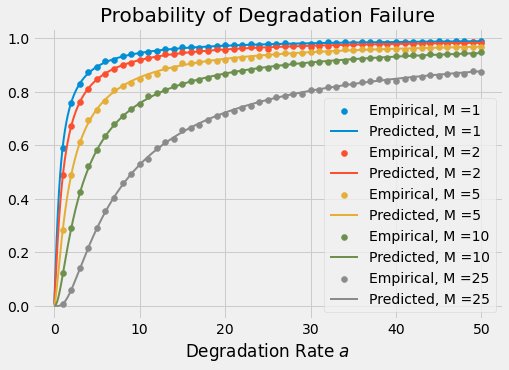

In [263]:
fig, (ax1) = plt.subplots(1, 1, figsize = (7.5, 5), sharex=True, sharey=False)

for i in range(mSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, M =' + str(mList[i])
    pLabel = 'Predicted, M =' + str(mList[i])

    # probability of decay crossing
    ax1.scatter(aSpace, empiricalArray[:,2], label = sLabel)
    ax1.plot(aSpace2, predictedArray[:,2], label = pLabel, linewidth = 2)

ax1.legend()
ax1.set_xlabel('Degradation Rate $a$')
#ax1.set_ylabel('Probability of Degradation Failure')

plt.title(r'Probability of Degradation Failure', fontsize = 20)

plt.savefig('DegradationFailure.png', bbox_inches = 'tight')

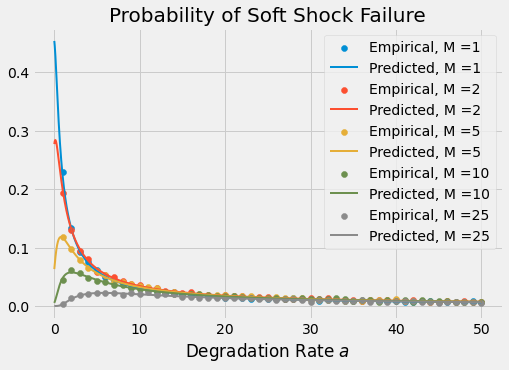

In [264]:
fig, (ax1) = plt.subplots(1, 1, figsize = (7.5, 5), sharex=True, sharey=False)

for i in range(mSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, M =' + str(mList[i])
    pLabel = 'Predicted, M =' + str(mList[i])

    # probability of decay crossing
    ax1.scatter(aSpace, empiricalArray[:,3], label = sLabel)
    ax1.plot(aSpace2, predictedArray[:,3], label = pLabel, linewidth = 2)

ax1.legend()
ax1.set_xlabel('Degradation Rate $a$')
#ax1.set_ylabel('Probability of Soft Shock Failure')

plt.title(r'Probability of Soft Shock Failure', fontsize = 20)

plt.savefig('SoftShockFailure.png', bbox_inches = 'tight')

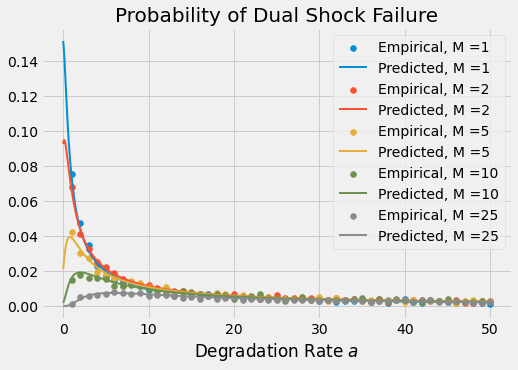

In [265]:
fig, (ax1) = plt.subplots(1, 1, figsize = (7.5, 5), sharex=True, sharey=False)

for i in range(mSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, M =' + str(mList[i])
    pLabel = 'Predicted, M =' + str(mList[i])

    # probability of decay crossing
    ax1.scatter(aSpace, empiricalArray[:,4], label = sLabel)
    ax1.plot(aSpace2, predictedArray[:,4], label = pLabel, linewidth = 2)

ax1.legend()
ax1.set_xlabel('Degradation Rate $a$')
#ax1.set_ylabel('Probability of Dual Shock Failure')

plt.title(r'Probability of Dual Shock Failure', fontsize = 20)

plt.savefig('DualShockFailure.png', bbox_inches = 'tight')

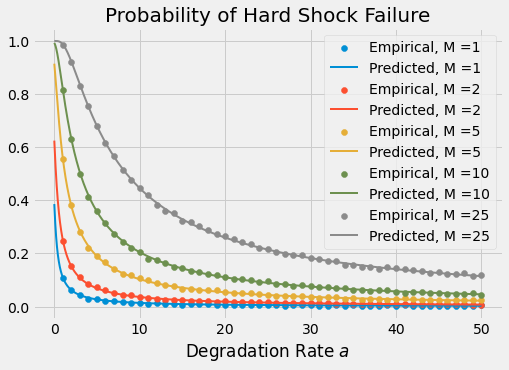

In [266]:
fig, (ax1) = plt.subplots(1, 1, figsize = (7.5, 5), sharex=True, sharey=False)

for i in range(mSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, M =' + str(mList[i])
    pLabel = 'Predicted, M =' + str(mList[i])

    # probability of decay crossing
    ax1.scatter(aSpace, empiricalArray[:,5], label = sLabel)
    ax1.plot(aSpace2, predictedArray[:,5], label = pLabel, linewidth = 2)

ax1.legend()
ax1.set_xlabel('Degradation Rate $a$')
#ax1.set_ylabel('Probability of Hard Shock Failure')

plt.title(r'Probability of Hard Shock Failure', fontsize = 20)

plt.savefig('HardShockFailure.png', bbox_inches = 'tight')

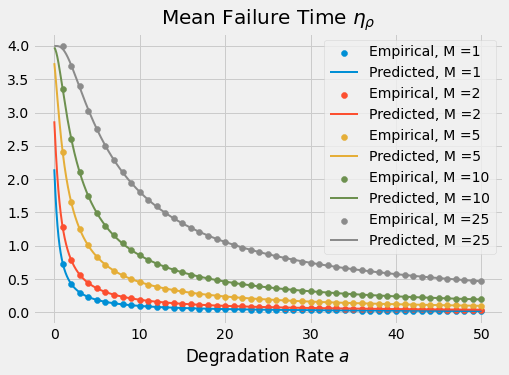

In [267]:
fig, ax1 = plt.subplots(1, 1, figsize = (7.5, 5), sharex=True, sharey=False)

for i in range(mSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, M =' + str(mList[i])
    pLabel = 'Predicted, M =' + str(mList[i])

    # mean crossing time
    plt.scatter(aSpace, empiricalArray[:,0], label = sLabel)    
    plt.plot(aSpace2, predictedArray[:,0], label = pLabel, linewidth = 2)

plt.legend()
plt.xlabel('Degradation Rate $a$')
#plt.ylabel('Mean of Failure Time')


plt.title(r'Mean Failure Time $\eta_\rho$', fontsize = 20)

plt.savefig('MeanFailureTime.png', bbox_inches = 'tight')

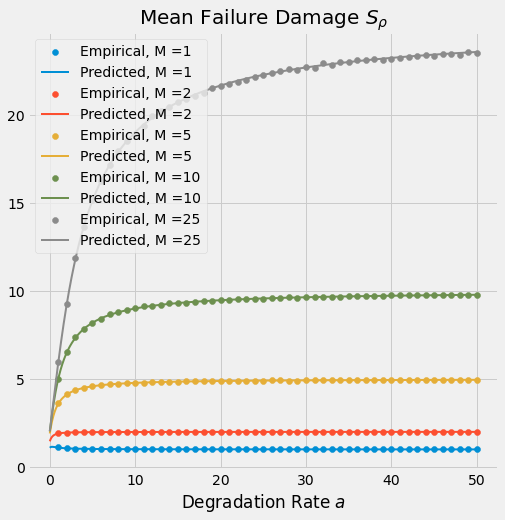

In [268]:
fig, ax1 = plt.subplots(1, 1, figsize = (7.5, 7.5), sharex=True, sharey=False)

for i in range(mSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, M =' + str(mList[i])
    pLabel = 'Predicted, M =' + str(mList[i])

    # mean crossing time
    plt.scatter(aSpace, empiricalArray[:,1], label = sLabel)    
    plt.plot(aSpace2, predictedArray[:,1], label = pLabel, linewidth = 2)

plt.legend()
plt.xlabel('Degradation Rate $a$')
#plt.ylabel('Mean of Failure Time')

plt.title(r'Mean Failure Damage $S_\rho$', fontsize = 20)

plt.savefig('MeanFailureDamage.png', bbox_inches = 'tight')

In [240]:
predictedArray[:,2].shape

(100,)

In [241]:
import pandas as pd

d = {'Degradation': predictedArray[:, 2], 'Soft Shock': predictedArray[:, 3], 'Dual Shock': predictedArray[:, 4], 'Hard Shock': predictedArray[:, 5]}
df = pd.DataFrame(d)

df

,Degradation,Soft Shock,Dual Shock,Hard Shock
0,6.695570e-08,0.000003,0.000001,0.999995
1,7.024947e-04,0.000587,0.000196,0.998515
2,8.910714e-03,0.003575,0.001192,0.986323
3,3.074245e-02,0.008051,0.002684,0.958522
4,6.362811e-02,0.012343,0.004114,0.919915
...,...,...,...,...
95,8.723778e-01,0.006809,0.002270,0.118544
96,8.736102e-01,0.006747,0.002249,0.117394
97,8.748191e-01,0.006687,0.002229,0.116265
98,8.760051e-01,0.006627,0.002209,0.115159


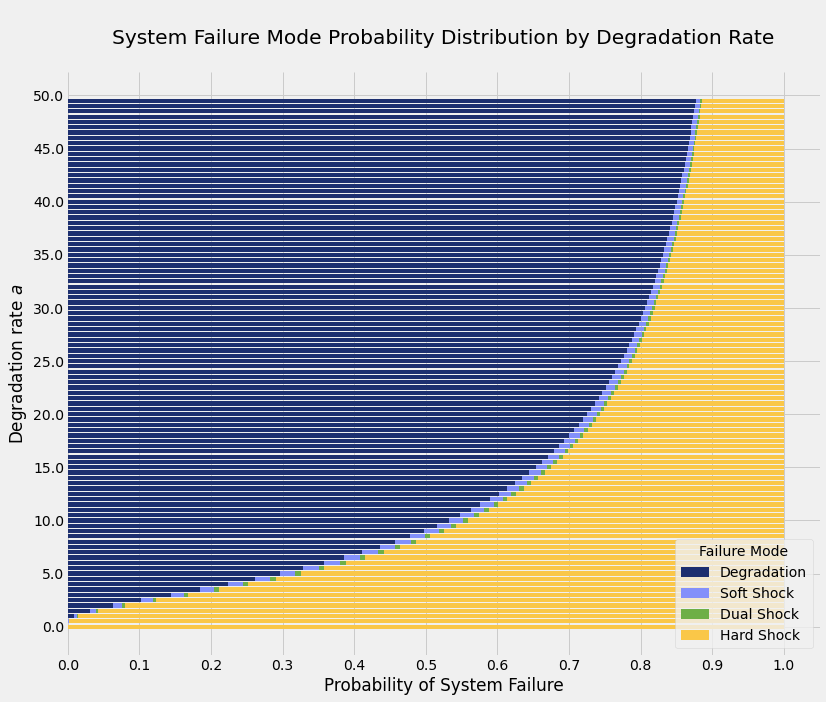

In [269]:
# variables
labels = ['Degradation', 'Soft Shock', 'Dual Shock', 'Hard Shock']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']
title = '\nSystem Failure Mode Probability Distribution by Degradation Rate\n'

def plot_stackedbar_p(df, labels, colors, title):
    fields = df.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))

    # plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left = left, color = colors[idx])
        left = left + df[name]

    # title and subtitle
    plt.title(title)
    
    # legend
    #plt.legend(labels, loc='upper center', ncol = 4, frameon = False)
    plt.legend(labels, loc = 'lower right', title = 'Failure Mode')

    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # format x ticks
    xticks = np.arange(0, 1.1, 0.1)
    xlabels = ['{}'.format(i/100) for i in np.arange(0, 101, 10)]
    plt.xticks(xticks, xlabels)
    plt.xlabel('Probability of System Failure')

    # adjust limits and draw grid lines
    yticks = np.arange(0, 101, 10)
    ylabels = ['{}'.format(np.round(i/100*50, 0)) for i in yticks]
    plt.yticks(yticks, ylabels)
    plt.ylabel('Degradation rate $a$')
               
    #ax.xaxis.grid(color='gray', linestyle='dashed')
    #plt.show()
    plt.savefig('FailureModeDistribution.png')
    
plot_stackedbar_p(df, labels, colors, title)

Text(0, 0.5, 'Probability')

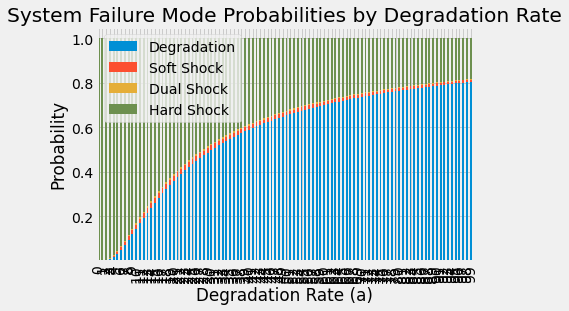

In [ ]:
#plt.figure(figsize=(30, 30))
import matplotlib

matplotlib.style.use('fivethirtyeight') 

df.plot(kind = 'bar', stacked = True'System Failure Mode Probabilities by Degradation Rate')
plt.xlabel('Degradation Rate (a)')

#xticks = np.arange(0,110,10)
#xlabels = ['{}'.format(i) for i in np.arange(0,33,3)]

#plt.xticks(xticks, xlabels)
    
'Probability')plt.ylabel()

plt.title(